In [8]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 30 20:11:19 2016

@author: stephen
"""

from __future__ import print_function

from tensorflow import keras
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:, 0]
    X = data[:, 1:]
    return X, Y


epochs = 400

flist = ["../../datasets/GunPoint/GunPoint"]

for each in flist:
    fname = each
    x_train, y_train = readucr(fname + "_TRAIN.txt")
    x_test, y_test = readucr(fname + "_TEST.txt")
    nb_classes = len(np.unique(y_test))
#     batch_size = int(min(x_train.shape[0] / 10, 16))
    batch_size = int(x_train.shape[0])

    y_train = (
        (y_train - y_train.min()) / (y_train.max() - y_train.min()) * (nb_classes - 1)
    )
    y_test = (y_test - y_test.min()) / (y_test.max() - y_test.min()) * (nb_classes - 1)

    Y_train = keras.utils.to_categorical(y_train, nb_classes)
    Y_test = keras.utils.to_categorical(y_test, nb_classes)

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean) / (x_train_std)

    x_test = (x_test - x_train_mean) / (x_train_std)
    x_train = x_train.reshape(
        x_train.shape
        + (
            1,
            1,
        )
    )
    x_test = x_test.reshape(
        x_test.shape
        + (
            1,
            1,
        )
    )

    x = keras.layers.Input(x_train.shape[1:])
    #    drop_out = Dropout(0.2)(x)
    conv1 = keras.layers.Conv2D(128, 8, 1, padding="same")(x)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation("relu")(conv1)

    #    drop_out = Dropout(0.2)(conv1)
    conv2 = keras.layers.Conv2D(256, 5, 1, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation("relu")(conv2)

    #    drop_out = Dropout(0.2)(conv2)
    conv3 = keras.layers.Conv2D(128, 3, 1, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation("relu")(conv3)

    full = keras.layers.GlobalAveragePooling2D()(conv3)
    out = keras.layers.Dense(nb_classes, activation="softmax")(full)

    model = keras.models.Model(inputs=x, outputs=out)

    optimizer = keras.optimizers.Adam()
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=50, min_lr=0.0001
    )
    
    es = EarlyStopping(monitor="val_loss", verbose=1, min_delta=1e-6, patience=50)
    
    hist = model.fit(
        x_train,
        Y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, Y_test),
        callbacks=[reduce_lr, es],
    )

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 0.7898 - accuracy: 0.5200 - val_loss: 0.6929 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 2/400
1/1 [==============================] - 1s 1s/step - loss: 0.7002 - accuracy: 0.4800 - val_loss: 0.6926 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/400
1/1 [==============================] - 1s 1s/step - loss: 0.7603 - accuracy: 0.5600 - val_loss: 0.6925 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/400
1/1 [==============================] - 1s 1s/step - loss: 0.6265 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 5/400
1/1 [==============================] - 1s 1s/step - loss: 0.6188 - accuracy: 0.5600 - val_loss: 0.6922 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 6/400
1/1 [==============================] - 1s 1s/step - loss: 0.5943 - accuracy: 0.6800 - val_loss: 0.6925 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 7/400
1/1 [==============================] - 1s 1s/step - loss: 0.5813 - accuracy: 0.660

Epoch 55/400
1/1 [==============================] - 2s 2s/step - loss: 0.1679 - accuracy: 0.9800 - val_loss: 0.7553 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 56/400
1/1 [==============================] - 2s 2s/step - loss: 0.1641 - accuracy: 0.9800 - val_loss: 0.7666 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 57/400
1/1 [==============================] - 2s 2s/step - loss: 0.1556 - accuracy: 0.9800 - val_loss: 0.7773 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 58/400
1/1 [==============================] - 2s 2s/step - loss: 0.1460 - accuracy: 1.0000 - val_loss: 0.7896 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 59/400
1/1 [==============================] - 2s 2s/step - loss: 0.1343 - accuracy: 1.0000 - val_loss: 0.8022 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 60/400
1/1 [==============================] - 2s 2s/step - loss: 0.1250 - accuracy: 1.0000 - val_loss: 0.8151 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 61/400
1/1 [==============================] - 2s 2s/step - loss: 0.1165 - accuracy

In [2]:
# evaluate the model
_, train_acc = model.evaluate(x_train, Y_train)
_, test_acc = model.evaluate(x_test, Y_test)

5/5 [==============================] - 0s 73ms/step - loss: 1.0599 - accuracy: 0.6867


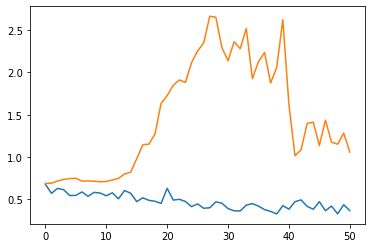

In [5]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

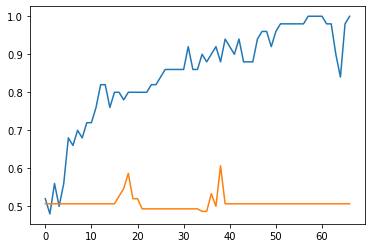

In [9]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.show()